In [ ]:
!pip install fastbook

In [2]:
!pip list | grep fastai

fastai                                2.7.10


In [3]:
from fastbook import (
    search_images_bing,
    download_url,
    Path,
    download_images,
    get_image_files,
    verify_images
)

In [4]:
import os
import time

In [ ]:
classes = {
    "picasso": "Pablo Picasso",
    "vanGogh": "Vincent van Gogh",
    "dali": "Salvador Dalí",
    "daVinci": "Leonardo da Vinci",
    "rembrandt": "Rembrandt",
}

In [ ]:
path = Path("paintings-by-autor")

In [ ]:
fns = get_image_files(path)
fns

## DataLoaders

In [14]:
from fastbook import (
    CategoryBlock,
    DataBlock,
    ImageBlock,
    RandomResizedCrop,
    RandomSplitter,
    Resize,
    aug_transforms,
    parent_label,
)

In [15]:
paintings_dl_template = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # dependent variable, type of target
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, # simply gets the name of the folder a file is in
    item_tfms=Resize(128)
)

In [16]:
data_loader = paintings_dl_template.dataloaders(path)
type(data_loader) 
# A DataLoaders includes validation and training DataLoaders
# A DataLoader (singular) provides batches of a few items at a time to the GPU

fastai.data.core.DataLoaders

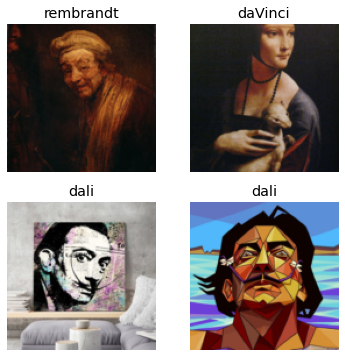

In [17]:
data_loader.valid.show_batch(max_n=4, nrows=2)

We have defined a Resize transformation, but because whit crop the image to fit the square dimension (128 pixels) we are losing some information from some images.

Instead we can select randomly part of the image, for each training epoch we will getting a different image, this a technique called **data augmentation**, useful to the model to generalize better.

In [ ]:
painting_dl_v2 = paintings_dl_template.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.3)
)
data_loader = painting_dl_v2.dataloaders(path)
data_loader.train.show_batch(max_n=4, nrows=1, unique=True)

Alternatively, we can use a set of transformation for data augmentation which are provided by the funcion: `aug_transforms`. An this transformations happen using the GPU because all the images are the same size.

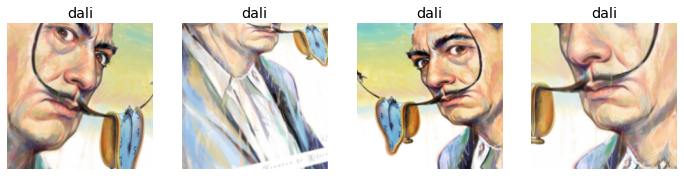

In [18]:
painting_dl_v3 = paintings_dl_template.new(
    item_tfms=RandomResizedCrop(224),
    batch_tfms=aug_transforms(),
)
data_loader = painting_dl_v3.dataloaders(path)
data_loader.train.show_batch(max_n=4, nrows=1, unique=True)

## Training the model and using it to clear your data

Currently there are 664 photos for the 5 authors.

In [19]:
from fastbook import (
    error_rate,
    resnet18,
    vision_learner,
)

By the way, this is the Resnet18 arch.

![](https://images.deepai.org/converted-papers/1902.08897/x3.png)

In [ ]:
?vision_learner

In [20]:
model = vision_learner(dls=data_loader, arch=resnet18, metrics=error_rate)

NUM_EPOCHS = 4
model.fine_tune(NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.358591,1.517536,0.417910,00:44


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.101578,0.791939,0.246269,00:43
1,0.925692,0.680240,0.164179,00:44
2,0.804822,0.639805,0.164179,00:44
3,0.720603,0.637945,0.164179,00:43


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [21]:
model.dls.vocab

['daVinci', 'dali', 'picasso', 'rembrandt', 'vanGogh']

Let's check the confusion matrix to know where the model had more trouble determining the correct class.

In [22]:
from fastbook import ClassificationInterpretation

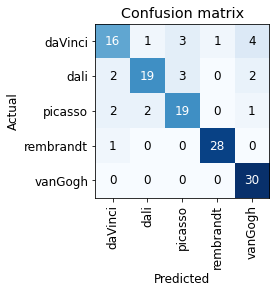

In [23]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

We had the most trouble with da Vinci and Dalí

`plot_top_losses` shows us the images with the highest loss in our dataset when was the training. As the title of the output says, each image is labeled with four things: 

prediction, actual (target label), loss, and probability.

In [24]:
?interp.plot_top_losses

Signature: interp.plot_top_losses(k: 'int | list', largest: 'bool' = True, **kwargs)
Docstring: Show `k` largest(/smallest) preds and losses. Implementation based on type dispatch
File:      /opt/conda/lib/python3.7/site-packages/fastai/interpret.py
Type:      method


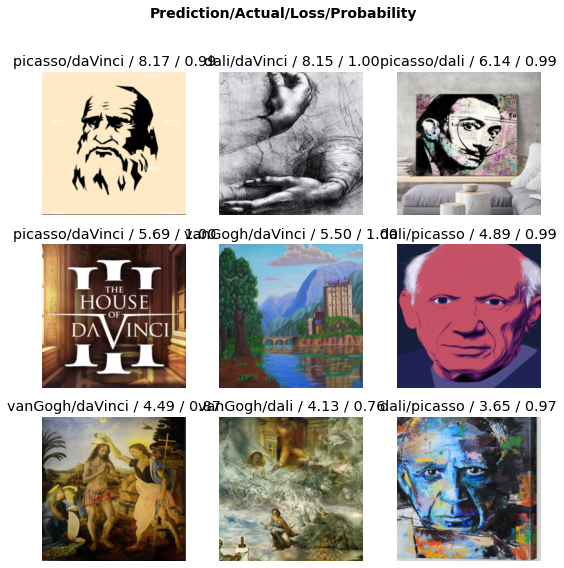

In [25]:
interp.plot_top_losses(9, nrows=3)

Let's clean a bit the dataset by using that insights and with a powerful class.

In [26]:
from fastai.vision.widgets import ImageClassifierCleaner

In [27]:
cleaner = ImageClassifierCleaner(model)
cleaner

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [28]:
# apply deletions
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [29]:
# apply re-labelings
for idx, category in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/category)

## Re-train model

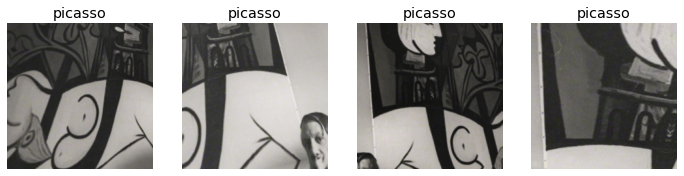

In [30]:
painting_dl_v4 = paintings_dl_template.new(
    item_tfms=RandomResizedCrop(224),
    batch_tfms=aug_transforms(),
)
data_loader = painting_dl_v4.dataloaders(path)
data_loader.train.show_batch(max_n=4, nrows=1, unique=True)

In [31]:
model_v2 = vision_learner(dls=data_loader, arch=resnet18, metrics=error_rate)

NUM_EPOCHS = 5
model_v2.fine_tune(NUM_EPOCHS)

epoch,train_loss,valid_loss,error_rate,time
0,2.076204,1.469697,0.406015,00:38


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.979423,0.928732,0.255639,00:38
1,0.860190,0.757741,0.218045,00:39
2,0.764358,0.677663,0.218045,00:38
3,0.686988,0.616659,0.225564,00:38
4,0.618359,0.586555,0.218045,00:38


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency e

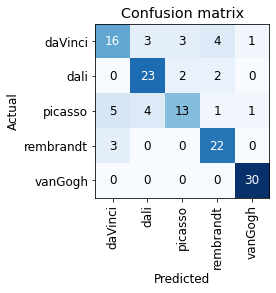

In [32]:
interp = ClassificationInterpretation.from_learner(model_v2)
interp.plot_confusion_matrix()

## Test model inference

In [33]:
from fastbook import (
    load_learner
)

In [34]:
model_v2.export()

In [35]:
# check pkl files
path = Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]

In [36]:
# load the model from from the disk
loaded_model = load_learner(path / "export.pkl")

In [37]:
sample_image_path = "paintings-by-autor/vanGogh/04ddcdf0-de03-4eb8-87c0-6bff83b8a254.jpg"
class_key, idx_cat, probs = loaded_model.predict(sample_image_path)

print(f"it's from {classes[class_key]}, confidence: {probs[idx_cat]}")

it's from Vincent van Gogh, confidence: 0.9980936646461487


In [ ]:
# we can check the categories and its order
loaded_model.dls.vocab

## Creating a Notebook App from the model

In [ ]:
import ipywidgets as widgets

from fastai.vision.all import PILImage

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
# we can use another widget to watch it
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

In [ ]:
# make inference
pred, pred_idx, probs = loaded_model.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Complete the GUI

In [ ]:
btn_run = widgets.Button(description="Classify")
btn_run

In [ ]:
btn_upload = widgets.FileUpload()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    result_value = f'Pred: {pred}; Proba: {probs[pred_idx]:.04f}'
    lbl_pred.value = result_value
    print(result_value)

btn_run.on_click(on_click_classify)

In [ ]:
widgets.VBox(
    [
        widgets.Label("Select your painting!"), 
        btn_upload,
        btn_run, 
        out_pl, 
        lbl_pred
    ]
)